In [1]:
'''
Author: Jinwan Huang
'''
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

if torch.cuda.is_available():  
  dev = "cuda:0" 
else:  
  dev = "cpu"  
device = torch.device(dev)

In [2]:
train_df = pd.read_csv('merged.csv',index_col=0)
label = train_df['sign']
data = train_df.drop(['Cell', 'sign'], axis=1)
print(label)

1       0
2       1
3       1
4       0
5       0
       ..
2149    0
2150    1
2151    0
2152    0
2153    0
Name: sign, Length: 2153, dtype: int64


In [3]:
from torch.utils.data import Dataset, DataLoader
class MNIST_dataset(Dataset):
    def __init__(self, data, label, rows=42000):
        self.imgnp = data.values
        self.labels = label.values
        self.rows = rows
    
    def __len__(self):
        return self.rows
    
    def __getitem__(self, idx):
        #image = torch.tensor(self.imgnp[idx], dtype=torch.float) / 255  # Normalize
        #image = image.view(1, 28, 28)  # (channel, height, width)
        image = torch.tensor(self.imgnp[idx], dtype=torch.float)
        image = image.view(1, 8, 2923)  # (channel, height, width)
        label = self.labels[idx]
        return (image, label)

In [4]:
trainloader = DataLoader(MNIST_dataset(data, label, 2153), batch_size=5, shuffle=True)
#print(trainloader)

In [5]:
dataiter = iter(trainloader)

In [6]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 2)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 2)
        self.fc1 = nn.Linear( 11680, 256)
        self.fc2 = nn.Linear(256, 84)
        self.fc3 = nn.Linear(84, 10)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1) 
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [7]:
net=Net()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)

In [8]:
running_loss_list = []

optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

running_loss_list = []
for epoch in range(5):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        # print statistics
        running_loss += loss.item()
        if i % 200 == 199:
            print('[%d, %5d] loss: %.3f' %
                 (epoch + 1, i + 1, running_loss / 200)
                 )
            running_loss_list.append(running_loss)
            running_loss = 0.0
print('Finished Training')

[1,   200] loss: 24.796
[1,   400] loss: 1.373
[2,   200] loss: 1.075
[2,   400] loss: 1.053
[3,   200] loss: 0.998
[3,   400] loss: 0.997
[4,   200] loss: 0.979
[4,   400] loss: 0.988
[5,   200] loss: 0.948
[5,   400] loss: 0.998
Finished Training


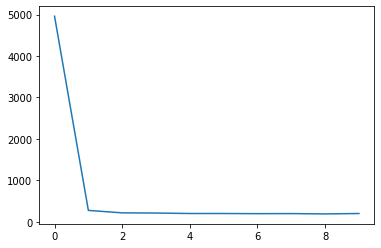

In [9]:
plt.plot(running_loss_list)

In [10]:
correct = 0
total = 0
with torch.no_grad():
    for data in trainloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print('Accuracy of the network on train images: ', correct/total)

Accuracy of the network on train images:0.4932652113330237
